In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 1. GPT-4 Vision API 이해하기
GPT-4 Vision API는 이미지 입력과 텍스트 프롬프트를 받아 이미지에 대한 상세한 설명이나 질문에 대한 답변을 생성해 줍니다. 이를 통해 이미지 캡셔닝, 장면 이해 등 다양한 작업에 활용할 수 있습니다.

In [ ]:
!pip install openai matplotlib pillow tqdm opencv-python

from typing import List, Optional
import os
import cv2
import openai
import base64
import io
import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image
import time
import re
import json
from tqdm import tqdm
from IPython.display import display, Image as IPImage

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 26.7 MB/s eta 0:00:00


In [ ]:
# OpenAI API 키 설정
OPENAI_KEY = # 실제 API 키로 대체하세요


In [ ]:
from openai import OpenAI

client = OpenAI(api_key=OPENAI_KEY)

In [ ]:
# 비디오에서 특정 프레임을 추출하는 함수
def read_video_opencv(video_path, frame_indices):
    """
    OpenCV를 사용하여 비디오에서 특정 프레임들을 추출합니다.

    Parameters:
    - video_path: 비디오 파일 경로
    - frame_indices: 추출할 프레임의 인덱스 리스트

    Returns:
    - 추출된 프레임들의 리스트 (NumPy 배열 형식) 또는 None
    """
    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"비디오 파일을 열 수 없습니다: {video_path}")
            return None

        frames = []
        frame_counter = 0
        frame_indices_set = set(frame_indices)

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            if frame_counter in frame_indices_set:
                frames.append(frame)
                if len(frames) == len(frame_indices):
                    break

            frame_counter += 1

        cap.release()

        if not frames:
            print("지정된 프레임 인덱스에 해당하는 프레임을 찾을 수 없습니다.")
            return None

        return frames

    except Exception as e:
        print(f"비디오에서 프레임 추출 중 오류 발생: {e}")
        return None



```
system_instruction = """
Analyze the input online presentation video to evaluate the presenter’s non-verbal behaviors, and provide feedback based on the following five categories. For each category, identify any inappropriate behaviors exhibited by the presenter, describe the strengths and areas for improvement in a specific manner, and include concrete examples whenever possible. Additionally, ensure that feedback for each item is provided in 1-2 lines and include the corresponding problematic behavior keyword if an inappropriate behavior is detected.

**Categories and Problematic Behavior Keywords:**

1. **Eye Contact**
   - **Excessive gaze shifting**: When the presenter frequently looks away from the camera or shifts their gaze too often, it disrupts connection with the audience.
   - **Irregular gaze dispersion**: Inconsistent eye contact, where the presenter glances in different directions without a consistent focus, can reduce engagement.

2. **Facial Expressions**
   - **Expressionless**: A lack of expression throughout the presentation can make it challenging for the audience to stay engaged.
   - **Excessive facial changes**: Frequent, abrupt changes in facial expressions can be distracting and reduce the effectiveness of the message.

3. **Gestures and Hand Movements**
   - **Excessive hand movements**: Constant or overly exaggerated hand movements may distract the audience from the presentation content.
   - **Unnecessary hand movements**: Movements not relevant to the content may make the presentation appear less professional.

4. **Posture and Body Language**
   - **Slouched posture**: Poor posture, such as slouching, can project a lack of confidence.
   - **Excessive movement**: Frequent shifting or large body movements may distract the audience and affect the presentation flow.

5. **Sudden Actions and Movements**
   - **Unexpected actions**: Abrupt actions or gestures without purpose can divert the audience’s attention unexpectedly.
   - **Disrupting presentation flow**: Actions that break the flow of the presentation can make it harder for the audience to follow the message.

**Feedback Format:**

- **Eye Contact**
  - **Strengths:** [Specific positive feedback]
  - **Areas for Improvement:** [Specific improvement suggestions] [Problematic Behavior Keyword]

- **Facial Expressions**
  - **Strengths:** [Specific positive feedback]
  - **Areas for Improvement:** [Specific improvement suggestions] [Problematic Behavior Keyword]

- **Gestures and Hand Movements**
  - **Strengths:** [Specific positive feedback]
  - **Areas for Improvement:** [Specific improvement suggestions] [Problematic Behavior Keyword]

- **Posture and Body Language**
  - **Strengths:** [Specific positive feedback]
  - **Areas for Improvement:** [Specific improvement suggestions] [Problematic Behavior Keyword]

- **Sudden Actions and Movements**
  - **Strengths:** [Specific positive feedback]
  - **Areas for Improvement:** [Specific improvement suggestions] [Problematic Behavior Keyword]

**Additional Guidelines:**
- When pointing out inappropriate behaviors, provide specific examples along with suggestions for improvement.
- Include the corresponding problematic behavior keyword at the end of the "Areas for Improvement" section if an inappropriate behavior is detected.
- Balance feedback by highlighting both positive and inappropriate behaviors to maintain the presenter’s motivation.
- Explain how the presenter’s behaviors relate to the objectives of the presentation.
- Use concrete examples to enhance the clarity of the feedback.

**Examples:**

- **Eye Contact**
  - **Strengths:** "You maintained steady eye contact with the camera throughout the presentation, effectively engaging the audience."
  - **Areas for Improvement:** "You were frequently looking away from the camera during the presentation. Maintaining eye contact with the camera will facilitate better communication." [Excessive gaze shifting]

- **Facial Expressions**
  - **Strengths:** "You used appropriate facial expressions when explaining key points, which made your message clearer."
  - **Areas for Improvement:** "You appeared expressionless throughout the presentation, making it difficult to capture the audience’s interest. Try using varied facial expressions to convey emotions." [Excessive facial changes]
"""

```



In [ ]:
system_instruction = """
당신은 15년 이상의 경력을 가진 온라인 발표 전문 코치입니다. 비언어적 커뮤니케이션 분야의 전문가로서, 수많은 발표자들이 비언어적 행동을 개선하도록 도왔습니다. 당신은 발표자의 온라인 발표에서의 제스처, 표정, 시선 처리, 자세 등이 청중에게 미치는 영향을 깊이 이해하고 있으며, 이를 토대로 구체적이고 실용적인 피드백을 제공합니다.
입력된 온라인 발표 영상을 분석하여 발표자의 비언어적 행동을 평가하고, 다음 다섯 가지 카테고리를 기준으로 피드백을 제공해주세요. 각 카테고리마다 발표자가 보인 부적절한 행동을 식별하고, 개선이 필요한 점을 구체적으로 서술하며, 가능한 경우 구체적인 예시를 포함해주세요. 피드백은 각 항목당 1~2줄로 간결하게 제공되며, 부적절한 행동이 감지된 경우 해당 문제 행동의 정의 키워드를 포함시켜주세요.

추가 지침:

- 부적절한 행동을 지적할 때는 구체적인 예시와 함께 개선 방안을 제시해주세요.
- 긍정적인 행동은 제외하고, 개선이 필요한 행동에 집중하여 피드백을 제공해주세요.
- 가능한 한 구체적인 예시를 들어 피드백의 명확성을 높여주세요.
- 하나의 카테고리에서 여러 부적절한 행동이 감지될 경우 모두 언급하여 발표자가 명확하게 이해할 수 있도록 합니다.

카테고리 및 부적절한 행동 키워드:

1. 시선 처리
   - 과도한 시선 이동
     - 예시: 발표자가 중요한 내용을 설명할 때마다 자주 화면 밖을 보거나 주변을 둘러보며 시선을 지속적으로 이동합니다.
     - 감지 기준:
       - 발표자의 눈이 카메라를 바라보지 않고 다른 곳을 응시함.
   - 불규칙한 시선 분산
     - 예시: 발표 중간중간 시선을 갑자기 왼쪽, 오른쪽, 아래 등 다양한 방향으로 자주 돌려 일관된 시선 유지를 하지 못합니다.
     - 감지 기준:
       - 시선을 특정 지점에 지속적으로 유지하지 못하고 불규칙하게 움직임.

2. 얼굴 표정
   - 무표정
     - 예시: 발표 내내 무표정을 유지하여 감정을 전달하지 못해 청중의 관심을 끌기 어렵습니다.
     - 감지 기준:
       - 발표 시간의 80% 이상 동안 얼굴에 변화가 거의 없음.
   - 과도한 표정 변화
     - 예시: 발표 도중 지나치게 많은 표정 변화를 보여 자연스럽지 않고 산만하게 보입니다.
     - 감지 기준:
       - 표정이 자주 변하여 청중의 집중을 방해함.

3. 제스처 및 손동작
   - 과도한 손동작
     - 예시: 발표 하는 도중에 갑자기 화면에 손이 나오거나, 손을 흔들거나 움직여 청중의 집중을 방해합니다.
     - 감지 기준:
       - 발표 내용과 관련 없는 손동작으로 청중의 주의를 분산시킴.
   - 불필요한 손동작
     - 예시: 발표 내용과 관련 없는 손동작을 반복적으로 사용하여 산만하게 만듭니다. 예를 들어, 설명과 무관하게 손을 계속해서 얼굴 가까이로 가져갑니다.
     - 감지 기준:
       - 손동작이 발표의 흐름과 무관하게 이루어져 청중의 집중을 방해함.

4. 자세 및 신체 언어
   - 구부정한 자세
     - 예시: 발표자가 자세를 바르게 하지 않고 고개를 숙이면서 청중의 집중을 방해합니다.
     - 감지 기준:
       - 갑자기 숙임, 화면을 벗어나는등 비전문적인 자세.
   - 과도한 움직임
     - 예시: 발표 중 자리에서 일어나거나, 몸을 좌우 앞뒤로 크게 움직여 발표의 흐름을 방해합니다.
     - 감지 기준:
       - 발표 화면내에서 허리와 등을 곧게 펴지 않는 자세
       - 발표의 흐름을 방해하고 청중의 집중을 흐트러뜨림.

5. 갑작스러운 행동 및 움직임
   - 예상치 못한 행동
     - 예시: 발표 도중 갑자기 손을 크게 올리거나, 몸을 급격하게 돌리는 등 예측할 수 없는 행동을 합니다. 예를 들어, 중요한 포인트 없이 갑자기 손을 크게 흔듭니다.
     - 감지 기준:
       - 발표 중 발표화면에서 발표자의 예상치 못한 행동이 발생.
       - 청중의 주의를 갑작스럽게 분산시켜 발표의 일관성을 해침.
   - 발표 흐름 방해
     - 예시: 발표 중 중요한 내용을 설명할 때 갑자기 손을 올려 청중의 주의를 분산시킵니다. 예를 들어, 슬라이드를 설명하는 도중에 불필요하게 손을 크게 움직입니다.
     - 감지 기준:
       - 발표 화면에서 발표 흐름을 방해하는 행동이 발생.
       - 발표의 일관성을 유지하지 못하고 청중의 집중을 분산시킴.

피드백 형식:

- 시선 처리
  - 개선이 필요한 점: "발표 중간에 자주 화면 밖을 보시는 모습이 관찰되었습니다. 카메라를 향해 시선을 유지하시면 더 효과적인 소통이 가능할 것입니다." [과도한 시선 이동]
  - 권장 사항: "카메라와 시선을 고정하여 청중과 일관된 연결을 유지하도록 연습해 보세요."

- 얼굴 표정
  - 개선이 필요한 점: "발표 내내 무표정하게 보이는 부분이 있어 청중의 관심을 끌기 어려웠습니다. 다양한 표정을 사용하여 감정을 표현해보세요." [무표정]
  - 권장 사항: "강조할 때나 중요한 순간에 미소나 표정 변화를 추가하면 더 생동감 있는 발표가 될 것입니다."

- 제스처 및 손동작
  - 개선이 필요한 점: "발표 도중 손을 너무 많이 흔드셔서 산만하게 보일 수 있었습니다. 주요 포인트에서만 손동작을 사용해보시면 좋겠습니다." [과도한 손동작]
  - 권장 사항: "핵심 포인트에만 손동작을 사용하여 발표의 주목도를 높여 보세요."

- 자세 및 신체 언어
  - 개선이 필요한 점: "발표 중간에 자주 자세가 바뀌는 모습이 보였습니다. 안정된 자세를 유지하시면 더욱 집중된 발표가 될 것입니다." [구부정한 자세]
  - 권장 사항: "앉거나 서 있을 때 몸을 일직선으로 유지해 안정감 있는 인상을 주도록 해보세요."

- 갑작스러운 행동 및 움직임
  - 개선이 필요한 점: "발표 도중 예상치 못한 손동작을 자주 사용하셨습니다. 손동작을 좀 더 계획적으로 사용하시면 좋을 것 같습니다." [예상치 못한 행동]
  - 권장 사항: "강조가 필요할 때만 움직임을 추가하여 청중의 집중을 유도하세요."


"""


In [ ]:
# 문제 행동의 정의 키워드 목록
PROBLEMATIC_BEHAVIORS = [
    "과도한 시선 이동",
    "불규칙한 시선 분산",
    "무표정",
    "과도한 표정 변화",
    "과도한 손동작",
    "불필요한 손동작",
    "구부정한 자세",
    "과도한 움직임",
    "예상치 못한 행동",
    "발표 흐름 방해"
]

In [ ]:
# 사용자 프롬프트 생성 함수
def generate_user_prompt(img_type, img_b64_str):
    """
    주어진 이미지 데이터와 타입을 기반으로 비언어적 행동 평가를 요청하는 사용자 프롬프트를 생성합니다.
    """
    return f"Please evaluate the presenter's non-verbal behavior.\n\nImage data: data:{img_type};base64,{img_b64_str}"


In [ ]:
# 이미지 인코딩 함수
def encode_image(image, max_size=(256, 256), quality=70):
    """
    이미지를 리사이즈하고 JPEG 형식으로 인코딩한 후 Base64 문자열로 반환합니다.

    Parameters:
    - image: OpenCV 형식의 이미지 (BGR)
    - max_size: 이미지의 최대 크기 (기본값: 256x256)
    - quality: JPEG 압축 품질 (기본값: 70)

    Returns:
    - Base64로 인코딩된 이미지 문자열 또는 None
    """
    try:
        # 현재 이미지의 크기 가져오기
        height, width = image.shape[:2]
        max_width, max_height = max_size

        # 비율 유지하며 크기 조정
        scaling_factor = min(max_width / width, max_height / height, 1)  # 원본보다 작게만 조정
        new_width = int(width * scaling_factor)
        new_height = int(height * scaling_factor)
        resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

        # JPEG로 인코딩
        encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
        result, encimg = cv2.imencode('.jpg', resized_image, encode_param)
        if not result:
            print("이미지 인코딩에 실패했습니다.")
            return None

        # Base64 인코딩
        img_b64_str = base64.b64encode(encimg.tobytes()).decode('utf-8')
        return img_b64_str
    except Exception as e:
        print(f"이미지 인코딩 중 오류 발생: {e}")
        return None

In [ ]:
# 비디오 길이 가져오기 함수
def get_video_duration(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Could not open video file: {video_path}")
        return None
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    duration = total_frames / fps
    cap.release()
    return duration

In [ ]:
# 비디오에서 프레임 추출 함수
def download_and_sample_video_local(video_path, start_time=0, duration=60, frame_interval=3):
    """
    주어진 비디오 파일에서 지정된 시작 시간과 지속 시간 내에서 일정 간격으로 프레임을 추출합니다.

    Parameters:
    - video_path: 비디오 파일 경로
    - start_time: 추출 시작 시간 (초 단위)
    - duration: 추출할 구간의 길이 (초 단위)
    - frame_interval: 프레임 추출 간격 (초 단위)

    Returns:
    - 추출된 프레임들의 리스트 (NumPy 배열 형식) 또는 None
    """
    try:
        # OpenCV로 비디오 캡처
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"비디오 파일을 열 수 없습니다: {video_path}")
            return None

        fps = cap.get(cv2.CAP_PROP_FPS)
        if fps == 0:
            fps = 30.0  # 기본 FPS 설정
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # 추출할 프레임 인덱스 계산
        start_frame = int(start_time * fps)
        end_frame = int((start_time + duration) * fps)
        frame_indices = list(range(start_frame, end_frame, int(frame_interval * fps)))

        frames = []
        frame_counter = 0

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            if frame_counter in frame_indices:
                frames.append(frame)
                if len(frames) == len(frame_indices):
                    break

            frame_counter += 1

        cap.release()

        if not frames:
            print("지정된 프레임 인덱스에 해당하는 프레임을 찾을 수 없습니다.")
            return None

        return np.array(frames)

    except Exception as e:
        print(f"비디오에서 프레임 추출 중 오류 발생: {e}")
        return None

In [ ]:
def analyze_frames(frames, segment_idx, duration, segment_length, system_instruction, frame_interval=3):
    problematic_frames = []
    feedbacks = []

    PROBLEMATIC_BEHAVIORS = [
        "과도한 시선 이동",
        "불규칙한 시선 분산",
        "무표정",
        "과도한 표정 변화",
        "과도한 손동작",
        "불필요한 손동작",
        "구부정한 자세",
        "과도한 움직임",
        "예상치 못한 행동",
        "발표 흐름 방해"
    ]

    num_frames = len(frames)
    time_stamps = [
        segment_idx * segment_length + i * frame_interval
        for i in range(num_frames)
    ]

    for i, (frame, frame_time_sec) in enumerate(zip(frames, time_stamps)):
        minutes = int(frame_time_sec // 60)
        seconds = int(frame_time_sec % 60)
        timestamp = f"{minutes}m {seconds}s"

        # 사용자 프롬프트 생성
        user_prompt = (
            "다음 이미지에서 발표자의 비언어적 행동을 분석하고, system_instruction 내용에 기반해서 문제가 되는 행동이 있으면 피드백을 제공해주세요. "
            "문제가 없으면 '문제 없음'이라고 답해주세요."
        )

        img_type = "image/jpeg"

        # 이미지를 인코딩
        img_b64_str = encode_image(frame)

        # 사용자 메시지 구성
        user_message = f"{user_prompt}\n\n이미지 데이터: data:{img_type};base64,{img_b64_str}"

        try:
            response = client.chat.completions.create(
                model="gpt-4o-mini",  # 사용 가능한 모델 이름으로 설정
                messages=[
                    {
                        "role": "system",
                        "content": system_instruction
                    },
                    {
                        "role": "user",
                        "content": user_message
                    }
                ],
                max_tokens=600,
            )

            # 생성된 텍스트와 문제 행동 추출
            generated_text = response.choices[0].message.content
            behaviors_detected = re.findall(r'\[([^\[\]]+)\]', generated_text)

            # 공백 제거
            behaviors_detected = [behavior.strip() for behavior in behaviors_detected]

            # 디버깅을 위해 감지된 문제 행동 출력
            print(f"[디버그] 프레임 {i+1} 응답 텍스트: {generated_text}")
            print(f"[디버그] 감지된 문제 행동: {behaviors_detected}")
            print(f"[디버그] PROBLEMATIC_BEHAVIORS 리스트: {PROBLEMATIC_BEHAVIORS}")

            # 문제 행동 감지 여부 확인
            problem_detected = any(behavior in PROBLEMATIC_BEHAVIORS for behavior in behaviors_detected)

            if problem_detected:
                # 프레임과 세그먼트 정보를 저장
                problematic_frames.append((frame, segment_idx + 1, i + 1, timestamp))
                feedbacks.append(generated_text)

        except openai.error.OpenAIError as e:
            print(f"프레임 {i+1} 처리 중 OpenAI 오류 발생: {e}")
        except Exception as e:
            print(f"프레임 {i+1} 처리 중 오류 발생: {e}")

    return problematic_frames, feedbacks


In [ ]:
def plot_problematic_frames(frames, feedbacks):
    if not frames:
        print("문제 있는 프레임이 없습니다.")
        return

    for i, (frame_info, feedback) in enumerate(zip(frames, feedbacks)):
        frame, segment_number, frame_number, timestamp = frame_info

        # 피드백을 콘솔에 출력
        print(f"Segment {segment_number}, Frame {frame_number} ({timestamp})")
        print("피드백:")
        print(feedback)
        print("-" * 50)

        # OpenCV의 BGR 이미지를 RGB로 변환하여 matplotlib에서 올바르게 표시
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # 이미지 표시
        plt.figure(figsize=(8, 6))
        plt.imshow(frame_rgb)
        plt.title(f"Segment {segment_number}, Frame {frame_number} ({timestamp})", fontsize=12)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

In [ ]:
def main():
    video_path = "/content/drive/MyDrive/kakaotech-14-ai/test_video2.mp4"  # 비디오 파일의 경로
    segment_length = 60  # 각 세그먼트의 길이 (초 단위)
    frame_interval = 3   # 프레임 추출 간격 (초 단위)

    # 비디오의 전체 길이(초 단위)를 가져옵니다.
    video_duration = get_video_duration(video_path)

    # 비디오를 세그먼트로 분할하기 위한 세그먼트 수 계산
    num_segments = math.ceil(video_duration / segment_length)
    print(f"비디오 전체 길이: {int(video_duration // 60)}분 {int(video_duration % 60)}초")
    print(f"총 {num_segments}개의 세그먼트로 분할됩니다.")

    all_segments_frames = []  # 모든 세그먼트의 프레임들을 저장할 리스트
    all_durations = []        # 각 세그먼트의 지속 시간을 저장할 리스트

    # 각 세그먼트별로 프레임을 추출합니다.
    for i in range(num_segments):
        start_time = i * segment_length  # 현재 세그먼트의 시작 시간 (초 단위)

        # 마지막 세그먼트의 지속 시간을 조정합니다.
        if i == num_segments - 1:
            duration = video_duration - start_time  # 남은 시간을 지속 시간으로 설정
        else:
            duration = segment_length  # 세그먼트 길이를 지속 시간으로 설정

        all_durations.append(duration)  # 세그먼트의 지속 시간을 저장

        print(f"샘플링 중인 세그먼트 {i+1}/{num_segments} (시작 시간: {int(start_time // 60)}분 {int(start_time % 60)}초)")

        # 해당 세그먼트에서 프레임을 추출합니다.
        clip = download_and_sample_video_local(
            video_path, start_time=start_time, duration=duration, frame_interval=frame_interval
        )

        # 추출된 프레임이 있으면 리스트에 추가합니다.
        if clip is not None and len(clip) > 0:
            all_segments_frames.append(clip)
        else:
            print(f"세그먼트 {i+1}에서 프레임을 추출할 수 없습니다.")

    print(f"총 {len(all_segments_frames)}개의 세그먼트가 추출되었습니다.")

    all_problematic_frames = []
    all_feedbacks = []

    # 모든 세그먼트에 대해 프레임 분석을 수행합니다.
    for idx, (segment_frames, duration) in enumerate(zip(all_segments_frames, all_durations)):
        print(f"\nAnalyzing segment {idx+1}/{len(all_segments_frames)}")
        # 각 세그먼트의 프레임들을 분석합니다.
        problematic_frames, feedbacks = analyze_frames(
            segment_frames, idx, duration, segment_length, system_instruction, frame_interval=frame_interval
        )
        all_problematic_frames.extend(problematic_frames)
        all_feedbacks.extend(feedbacks)

    # 문제 있는 프레임들을 시각화합니다.
    plot_problematic_frames(all_problematic_frames, all_feedbacks)


비디오 전체 길이: 2분 3초
총 3개의 세그먼트로 분할됩니다.
샘플링 중인 세그먼트 1/3 (시작 시간: 0분 0초)
샘플링 중인 세그먼트 2/3 (시작 시간: 1분 0초)
샘플링 중인 세그먼트 3/3 (시작 시간: 2분 0초)
총 3개의 세그먼트가 추출되었습니다.

Analyzing segment 1/3
[디버그] 프레임 1 응답 텍스트: 문제 없음
[디버그] 감지된 문제 행동: []
[디버그] PROBLEMATIC_BEHAVIORS 리스트: ['과도한 시선 이동', '불규칙한 시선 분산', '무표정', '과도한 표정 변화', '과도한 손동작', '불필요한 손동작', '구부정한 자세', '과도한 움직임', '예상치 못한 행동', '발표 흐름 방해']
[디버그] 프레임 2 응답 텍스트: 문제 없음.
[디버그] 감지된 문제 행동: []
[디버그] PROBLEMATIC_BEHAVIORS 리스트: ['과도한 시선 이동', '불규칙한 시선 분산', '무표정', '과도한 표정 변화', '과도한 손동작', '불필요한 손동작', '구부정한 자세', '과도한 움직임', '예상치 못한 행동', '발표 흐름 방해']
[디버그] 프레임 3 응답 텍스트: 문제 없음
[디버그] 감지된 문제 행동: []
[디버그] PROBLEMATIC_BEHAVIORS 리스트: ['과도한 시선 이동', '불규칙한 시선 분산', '무표정', '과도한 표정 변화', '과도한 손동작', '불필요한 손동작', '구부정한 자세', '과도한 움직임', '예상치 못한 행동', '발표 흐름 방해']
[디버그] 프레임 4 응답 텍스트: - 시선 처리
  - 개선이 필요한 점: "발표 중간에 자주 시선을 화면 밖이나 아래로 이동하시는 모습이 관찰되었습니다. 카메라를 더욱 주의 깊게 바라보셔야 청중과의 연결이 강화됩니다." [과도한 시선 이동]
  - 권장 사항: "중요한 포인트나 질문을 할 때는 카메라를 바라보면서 시선을 고정하는 연습을 해보세요."

- 얼굴 표정
  - 개선이 필요한 점: "발표 내내 표정 변화가

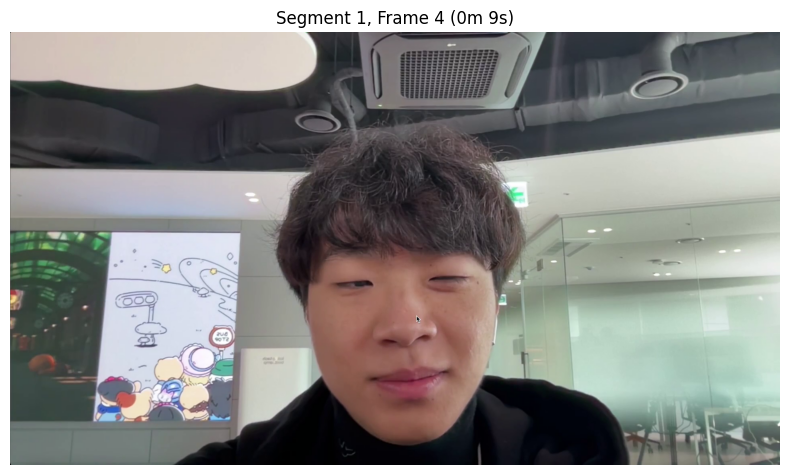

Segment 2, Frame 18 (1m 51s)
피드백:
- 시선 처리
  - 개선이 필요한 점: "발표자께서 강연 중 카메라를 바라보지 않고 주변을 둘러보며 지속적으로 시선을 이동하는 모습이 관찰되었습니다. 카메라 시선 유지를 통해 청중과의 연결을 강화하실 수 있습니다." [과도한 시선 이동]
  - 권장 사항: "발표하는 동안 카메라를 응시하는 연습을 하여 일관된 시선을 유지하도록 해보세요."

- 얼굴 표정
  - 개선이 필요한 점: "발표하는 내내 무표정하게 보이는 경향이 있어 청중의 감정적 관심을 끌기 어려웠습니다. 다채로운 표정으로 감정을 표현해 보세요." [무표정]
  - 권장 사항: "중요한 포인트를 강조할 때 미소나 다양한 표정을 추가하면 청중의 관심을 유도할 수 있습니다."

- 제스처 및 손동작
  - 개선이 필요한 점: "발표 중 손을 과도하게 흔들거나 움직이는 모습이 있어 청중의 주의를 분산시킬 수 있었습니다. 주요 내용에 대해 제스처를 제한해 보시면 좋겠습니다." [과도한 손동작]
  - 권장 사항: "핵심적인 내용에서만 손동작을 사용하여 발표의 주목도를 높이는 연습을 해보세요."

- 자세 및 신체 언어
  - 개선이 필요한 점: "발표 중기대의 자세가 불안정한 모습을 보였고, 고개를 숙이거나 구부정한 자세가 자주 관찰되었습니다. 안정된 자세를 유지하시면 발표에 더 집중할 수 있습니다." [구부정한 자세]
  - 권장 사항: "앉거나 서 있을 때 몸을 똑바로 세우고 안정적인 자세를 유지하는 연습을 해보세요."

- 갑작스러운 행동 및 움직임
  - 개선이 필요한 점: "발표 중간에 갑자기 손을 크게 올리거나 몸을 돌리는 등 예상치 못한 행동이 있었으며, 이는 청중의 집중을 분산시킬 수 있습니다." [예상치 못한 행동]
  - 권장 사항: "발표의 흐름을 해치지 않도록 계획적으로 손동작을 사용하여 청중의 관심을 유지하세요."
--------------------------------------------------


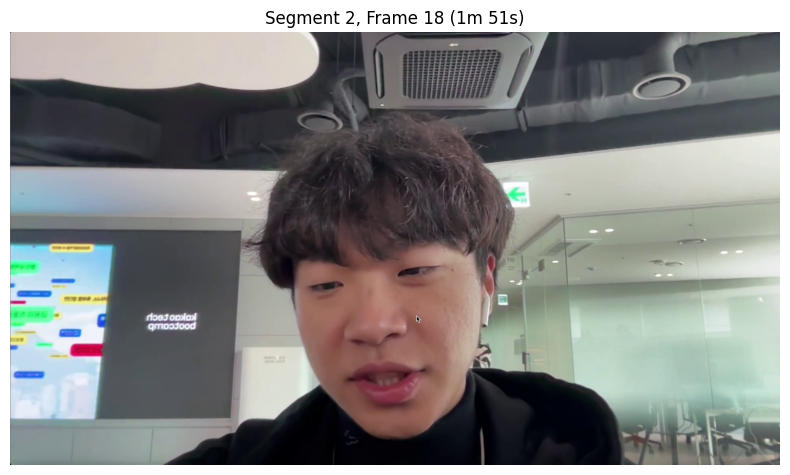

In [ ]:
if __name__ == "__main__":
    main()

ver1. 해결문제
- 정확도 이슈 (일단 정확하게 올려야 할지도 -> 파인튜닝 필요..?)
- 프레임 간격 더 줄이기 (3초 -> 1초)
- webm 형태로 제공? 이건 추후 의논 필요.